In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker
from PIL import Image
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fractions import Fraction
font = {'family' : 'Times New Roman',
    'weight' : 'light',
    'size'   : 13,
    }
plt.rc('font',family='Times New Roman')

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'  # 用于正常数学文本
matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'  # 用于斜体数学文本

#def curve_color():
def set_axis(axes,xmaj=0.5,xmin=0.125,ymaj=0.5,ymin=0.125,aspect=None):
    if aspect:
        axes.set_aspect(aspect)
    axes.minorticks_on()
    axes.tick_params(axis="both", which="major", direction="in", width=1, length=4, labelsize=10)
    axes.tick_params(axis="both", which="minor", direction="in", width=1, length=2, labelsize=10)

    axes.xaxis.set_major_locator(MultipleLocator(xmaj))
    axes.xaxis.set_minor_locator(MultipleLocator(xmin))
    axes.yaxis.set_major_locator(MultipleLocator(ymaj))
    axes.yaxis.set_minor_locator(MultipleLocator(ymin))

In [ ]:
class solver:
    def __init__(self,nx=200,nt=1000,ts=0.2,gamma=1.4,init_l=np.array([1,0,1]),init_r=np.array([0.125,0,0.1])):
        """"
        nx: the number of cells, or the total number of nodes is nx+1
        nt: the number of iterations
        u1: (3,nx), (\rho, u, p)
        u: (3,nx), (\rho, \rho u, \rho E)
        x_range: position of the left interfaces of the control volume
        """
        self.gamma=gamma
        self.nx=nx
        self.nt=nt
        
        self.dx=1./nx
        self.dt=ts/nt
        self.dt_list=[]
        self.x_range=np.arange(0,1.0,self.dx)
        self.t_range=np.arange(0,ts+self.dt,self.dt)

        self.u=np.zeros((3,nx))
        self.u1=np.zeros((3,nx))

        self.init_l=self.convert1(init_l)
        self.init_r=self.convert1(init_r)
        a=np.tile(np.where(self.x_range<=0.5,1,0),3).reshape(3,nx)
        a1=np.tile(init_l,nx).reshape(nx,3).T
        a2=np.tile(init_r,nx).reshape(nx,3).T
        self.u1=a1*a+a2*(1-a)
        self.u=self.convert1(self.u1)

    def convert1(self,u1):
        return np.array([u1[0],u1[1]*u1[0],u1[2]/(self.gamma-1)+1/2*u1[0]*u1[1]**2])
    
    def convert2(self,u):
        return np.array([u[0],u[1]/u[0],(self.gamma-1)*(u[2]-u[1]**2/(2*u[0]))])

    def rflux(self, ul, ur, entropyfix):
        """"
        Calculate \hat F_{j+1/2}^n with Ul and Ur
        Ul: (3,), Ur: (3,)
        """
        rhoL,rhoR=ul[0],ur[0]
        uL,uR=ul[1]/ul[0],ur[1]/ur[0]
        pL,pR=(self.gamma-1)*(ul[2]-1/2*rhoL*uL**2),(self.gamma-1)*(ur[2]-1/2*rhoR*uR**2)
        hL,hR=(ul[2]+pL)/rhoL,(ur[2]+pR)/rhoR
        
        def flux(u):
            return np.array([u[1],\
                u[1]**2/u[0]+(self.gamma-1)*(u[2]-u[1]**2/(2*u[0])),\
                u[1]/u[0]*(u[2]+(self.gamma-1)*(u[2]-u[1]**2/(2*u[0])))])
        fluxl=flux(ul)
        fluxr=flux(ur)

        lrhosqrt=np.sqrt(ul[0])
        rrhosqrt=np.sqrt(ur[0])
        rr=rrhosqrt*lrhosqrt
        uu=(lrhosqrt*uL+rrhosqrt*uR)/(rrhosqrt+lrhosqrt)
        hh=(lrhosqrt*hL+rrhosqrt*hR)/(rrhosqrt+lrhosqrt)
        aa=np.sqrt((self.gamma-1)*(hh-1/2*uu**2))
        
        r1=np.array([1,uu-aa,hh-uu*aa])
        r2=np.array([1,uu,1/2*uu**2])
        r3=np.array([1,uu+aa,hh+uu*aa])

        alpha1=(pR-pL-rr*aa*(uR-uL))/(2*aa**2)
        alpha2=rhoR-rhoL-(pR-pL)/(aa**2)
        alpha3=(pR-pL+rr*aa*(uR-uL))/(2*aa**2)

        if entropyfix:
            def EntropyFix(lamb,eps=0.15*aa):
                return lamb if lamb>eps else (lamb**2+eps**2)/(2*eps)
            rflux=1/2*(fluxl+fluxr)\
                -1/2*(EntropyFix(np.abs(uu-aa))*(r1*alpha1)\
                    +EntropyFix(np.abs(uu))*(r2*alpha2)\
                        +EntropyFix(np.abs(uu+aa))*(r3*alpha3))
        else:
            rflux=1/2*(fluxl+fluxr)\
                -1/2*(np.abs(uu-aa)*(r1*alpha1)\
                    +np.abs(uu)*(r2*alpha2)\
                        +np.abs(uu+aa)*(r3*alpha3))
        return rflux

    def saves(self,arg,tt,data,i):
        if 'freq' in arg.keys() and tt%arg['freq']==0:
            arg['list'].append((tt,data))
            return True
        elif 'time' in arg.keys() and i<len(arg['time']) and round(tt*self.dt,4)<=round(arg['time'][i],4)<round((tt+1)*self.dt,4):
            arg['list'].append((tt,data))
            return True
        return False
    
    def solve(self, arg_save=None,entropyfix=False):
        print('Solving the equation, nt: {}'.format(self.nt))    
        count=0
        for tt in range(self.nt+1):
            if arg_save and self.saves(arg_save, tt, self.u1.copy(),count):
                count+=1
            rflux=np.zeros((3,self.nx+1))
            for i in range(1,self.nx):
                rflux[:,i]=self.rflux(self.u[:,i-1],self.u[:,i],entropyfix)
            rflux[:,0]=self.rflux(self.u[:,0],self.u[:,0],entropyfix)
            rflux[:,-1]=self.rflux(self.u[:,-1],self.u[:,-1],entropyfix)
            self.u-=self.dt/self.dx*(rflux[:,1:]-rflux[:,:-1])
            self.u1=self.convert2(self.u)
        

In [ ]:
set_save_t=lambda _list, time=1: {'list': _list, 'time':time}
class plotter:
    def __init__(self):
        self._list=[]
        self.time_list=[]
        
    def plot_result_t1(self,exact=1,ymax=[1.2,1.2,1.2],ymin=[-0.1,-0.1,-0.1],path="./Riemann/rho1.0-0.125,u0,p1.0-0.1/"):
        def txt_to_vectors(file_path, delimiter=' '):
            vectors = []
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    line = line.strip()
                    if line:
                        try:
                            vector = [float(num) for num in line.split(delimiter)]
                            vectors.append(vector)
                        except ValueError:
                            print(f"忽略无效行：{line}")
            return np.array(vectors)
        
        f, axarr = plt.subplots(len(self._list), 3, figsize=(10, 4),sharex=True)
        plt.gcf().subplots_adjust(bottom=0.25)
        for i in range(len(self._list)):
            if exact:
                file_path=path+'ExactSol_{:.2f}.txt'.format(self._list[i][0]*self.dt)
                vectors = txt_to_vectors(file_path)
                axarr[i][0].plot(vectors[0]+0.5,vectors[2],color='r',linestyle='--',label=r'Exact Solution - $\rho$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
                axarr[i][1].plot(vectors[0]+0.5,vectors[1],color='g',linestyle='--',label=r'Exact Solution - $u$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
                axarr[i][2].plot(vectors[0]+0.5,vectors[3],color='b',linestyle='--',label=r'Exact Solution - $p$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))

            if ymax[0]>10: 
                set_axis(axarr[i][0],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
            elif 4<ymax[0]<=10:
                set_axis(axarr[i][0],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
            else:
                set_axis(axarr[i][0],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            if ymax[1]>10:
                set_axis(axarr[i][1],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
            elif 4<ymax[1]<=10:
                set_axis(axarr[i][1],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
            else:
                set_axis(axarr[i][1],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            if ymax[2]>10:
                set_axis(axarr[i][2],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
            elif 4<ymax[2]<=10:
                set_axis(axarr[i][2],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
            else:
                set_axis(axarr[i][2],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            
            axarr[i][1].set_xlim([-0.1, 1.1])
            axarr[i][0].set_xlim([-0.1, 1.1])
            axarr[i][2].set_xlim([-0.1, 1.1])
            axarr[i][1].set_ylim([ymin[0], ymax[0]])
            axarr[i][0].set_ylim([ymin[1], ymax[1]])
            axarr[i][2].set_ylim([ymin[2], ymax[2]])
            
            axarr[i][0].set_ylabel(r'$\rho$')
            axarr[i][1].set_ylabel(r'$u$')
            axarr[i][2].set_ylabel(r'$p$')
            axarr[i][0].text(0.75,0.75*ymax[0],r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[i][1].text(0.75,0.75*ymax[1],r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[i][2].text(0.75,0.75*ymax[2],r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[i][0].plot(self.x_range,self._list[i][1][0],'r',label=r'Numerical Solution - $\rho$')
            axarr[i][1].plot(self.x_range,self._list[i][1][1],'g',label=r'Numerical Solution - $u$')
            axarr[i][2].plot(self.x_range,self._list[i][1][2],'b',label=r'Numerical Solution - $p$')
            
            lines = []
            labels = []
            for ax in axarr[0]:
                axLine, axLabel = ax.get_legend_handles_labels()
                lines.extend(axLine)
                labels.extend(axLabel)

            f.legend(lines, labels,           
                    loc = 'lower center', ncols=3)  
        axarr[i][0].set_xlabel(r'$x$')
        axarr[i][1].set_xlabel(r'$x$')
        axarr[i][2].set_xlabel(r'$x$')
        plt.show()

    def plot_result_t(self,exact=1,ymax=[1.2,1.2,1.2],ymin=[-0.1,-0.1,-0.1],path="./Riemann/rho1.0-0.125,u0,p1.0-0.1/"):
        def txt_to_vectors(file_path, delimiter=' '):
            vectors = []
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    line = line.strip()
                    if line:
                        try:
                            vector = [float(num) for num in line.split(delimiter)]
                            vectors.append(vector)
                        except ValueError:
                            print(f"忽略无效行：{line}")
            return np.array(vectors)
        for i in range(len(self._list)):
            f, axarr = plt.subplots(1, 3, figsize=(12, 3))
            if exact:
                file_path=path+'ExactSol_{:.2f}.txt'.format(self._list[i][0]*self.dt)
                vectors = txt_to_vectors(file_path)
                axarr[0].plot(vectors[0]+0.5,vectors[2],color='r',linestyle='--',label=r'Exact Solution - $\rho$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
                axarr[1].plot(vectors[0]+0.5,vectors[1],color='g',linestyle='--',label=r'Exact Solution - $u$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
                axarr[2].plot(vectors[0]+0.5,vectors[3],color='b',linestyle='--',label=r'Exact Solution - $p$',alpha=0.8)#,label=r'Numerical $t=$'+'{:.1f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))

            if ymax[0]>10: 
                set_axis(axarr[0],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
            elif 4<ymax[0]<=10:
                set_axis(axarr[0],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
            else:
                set_axis(axarr[0],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            if ymax[1]>10:
                set_axis(axarr[1],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
            elif 4<ymax[1]<=10:
                set_axis(axarr[1],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
            else:
                set_axis(axarr[1],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            if ymax[2]>10:
                set_axis(axarr[2],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
            elif 4<ymax[2]<=10:
                set_axis(axarr[2],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
            else:
                set_axis(axarr[2],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
            
            axarr[1].set_xlim([-0.1, 1.1])
            axarr[0].set_xlim([-0.1, 1.1])
            axarr[2].set_xlim([-0.1, 1.1])
            axarr[1].set_ylim(ymin[0], ymax[0])
            axarr[0].set_ylim(ymin[1], ymax[1])
            axarr[2].set_ylim(ymin[1], ymax[2])
            axarr[0].text(0.75,0.75*ymax[0],r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[1].text(0.75,0.75*ymax[1],r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[2].text(0.75,0.75*ymax[2],r'$t={:.2f}$s'.format(self._list[i][0]*self.dt))
            axarr[0].set_xlabel(r'$x$')
            axarr[1].set_xlabel(r'$x$')
            axarr[2].set_xlabel(r'$x$')
            axarr[0].set_ylabel(r'$\rho$')
            axarr[1].set_ylabel(r'$u$')
            axarr[2].set_ylabel(r'$p$')
            axarr[0].plot(self.x_range,self._list[i][1][0],'r',label=r'Numerical Solution - $\rho$')
            axarr[0].legend(loc='upper right')
            axarr[1].legend(loc='upper right')
            axarr[2].legend(loc='upper right')
            f.suptitle('Shock Tube Problem ($t = {:.3f}$s)'.format(round(self.dt*self._list[i][0], 3)))
            plt.show()

    def animation(self,name,ymax=[1.2,1.2,1.2],ymin=[-0.1,-0.1,-0.1]):
        fig, axs = plt.subplots(3,sharex=True)

        line_1, = axs[0].plot(self.x_range, self._list[0][1][0], 'cornflowerblue', label = 'Velocity')
        line_2, = axs[1].plot(self.x_range, self._list[0][1][1], 'lightgreen', label = 'Density')
        line_3, = axs[2].plot(self.x_range, self._list[0][1][2], 'pink', label = 'Pressure')

        axs[0].legend(loc='upper right')
        axs[1].legend(loc='upper right')
        axs[2].legend(loc='upper right')

        axs[0].set_ylim(ymin[0], ymax[0])
        axs[1].set_ylim(ymin[1], ymax[1])
        axs[2].set_ylim(ymin[2], ymax[2])

        axs[0].set_ylabel('Velocity($u$)')
        axs[1].set_ylabel('Dentsity($\\rho$)')
        axs[2].set_xlabel('Space($x$)')
        axs[2].set_ylabel('Pressure($p$)')
        if ymax[0]>10: 
            set_axis(axs[0],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
        elif 4<ymax[0]<=10:
            set_axis(axs[0],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
        else:
            set_axis(axs[0],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
        if ymax[1]>10:
            set_axis(axs[1],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
        elif 4<ymax[1]<=10:
            set_axis(axs[1],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
        else:
            set_axis(axs[1],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
        if ymax[2]>10:
            set_axis(axs[2],xmaj=0.25,xmin=0.25,ymaj=5,ymin=5)
        elif 4<ymax[2]<=10:
            set_axis(axs[2],xmaj=0.25,xmin=0.25,ymaj=2,ymin=2)
        else:
            set_axis(axs[2],xmaj=0.25,xmin=0.25,ymaj=0.5,ymin=0.5)
        def update(num, u, rho, p , line_1, line_2, line_3):
            line_1.set_ydata(u[:, num])
            line_2.set_ydata(rho[:, num])
            line_3.set_ydata(p[:, num])
            fig.suptitle('Shock Tube Problem ($t = {:.3f}$s)'.format(round(self.dt*num, 3)))
            return line_1,line_2,line_3,
    
        plt_u=np.zeros((len(self._list),self.nx))
        plt_rho=np.zeros((len(self._list),self.nx))
        plt_p=np.zeros((len(self._list),self.nx))
        for i in range(len(self._list)):
            plt_u[i]=self._list[i][1][1]
            plt_rho[i]=self._list[i][1][0]
            plt_p[i]=self._list[i][1][2]
        plt_u=plt_u.T
        plt_rho=plt_rho.T
        plt_p=plt_p.T
        ani = FuncAnimation(fig, update, frames=range(1,len(self._list),20), fargs=[plt_u,plt_rho,plt_p,line_1,line_2,line_3], interval = 10)
            
        ani.save(name+'.gif', writer='pillow')
        plt.show()

In [4]:
class Roe(solver,plotter):
    def __init__(self,nx=200,nt=1000,ts=0.2,gamma=1.4,init_l=np.array([1,0,1]),init_r=np.array([0.125,0,0.1])):
        super().__init__(nx,nt,ts,gamma,init_l,init_r)
        self._list=[]
        self.time_list=[i for i in self.t_range]#[0,0.05,0.10,0.15,0.20,0.25]
        print('Method: Roe, nx: {}, dx: {}, dt: {}, dt: {}'.format(self.nx, self.dx, self.nt, self.dt))
    
    def solve(self):
        solver.solve(self,arg_save=set_save_t(self._list,self.time_list))

class RoeEntroyFix(solver,plotter):
    def __init__(self,nx=200,nt=1000,ts=0.2,gamma=1.4,init_l=np.array([1,0,1]),init_r=np.array([0.125,0,0.1])):
        super().__init__(nx,nt,ts,gamma,init_l,init_r)
        self._list=[]
        self.time_list=[i for i in self.t_range]#[0,0.05,0.10,0.15,0.20,0.25]
        print('Method: RoeEntropyFix, nx: {}, dx: {}, dt: {}, dt: {}'.format(self.nx, self.dx, self.nt, self.dt))
    
    def solve(self):
        solver.solve(self,arg_save=set_save_t(self._list,self.time_list),entropyfix=True)

Method: Roe, nx: 200, dx: 0.005, dt: 1000, dt: 0.0002
Solving the equation, nt: 1000


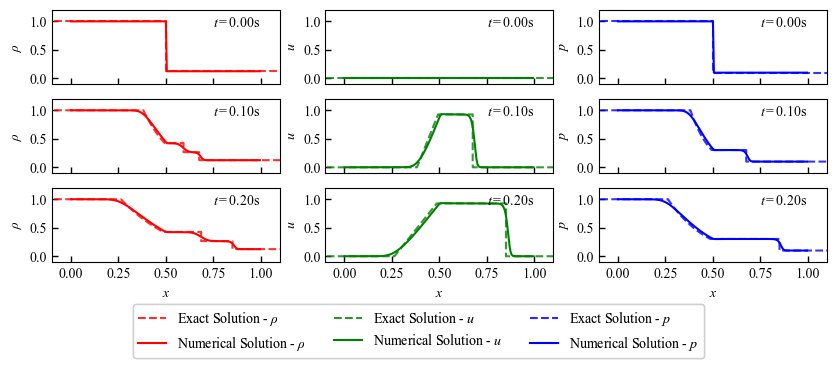

In [ ]:
roe=Roe(nt=1000,ts=0.2)#nx=200,nt=1000
roe.time_list=[0.0,0.10,0.20]
roe.solve()
roe.plot_result_t1()
#roe.animation('roe_1')

Method: Roe, nx: 200, dx: 0.005, dt: 1000, dt: 0.0002
Solving the equation, nt: 1000


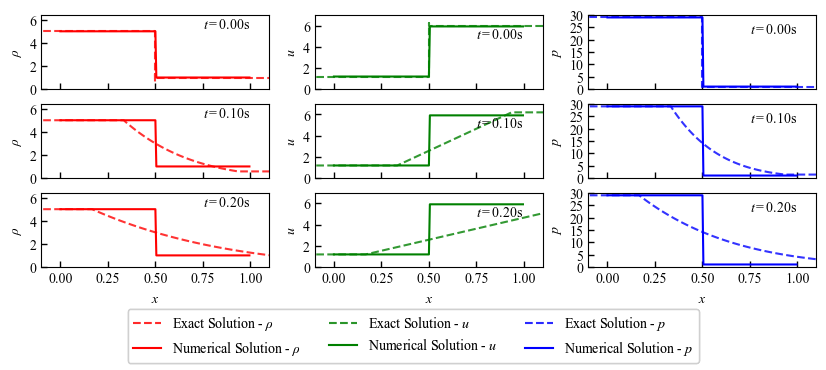

In [ ]:
roe=Roe(nt=1000,ts=0.2,init_l=np.array([5,np.sqrt(1.4),29]),init_r=np.array([1.0,5*np.sqrt(1.4),1.0]))#nx=200,nt=1000
roe.time_list=[0.0,0.10,0.20]
roe.solve()
roe.plot_result_t1(path='./Riemann/rho5.0-1.0,usqrt1.4-5sqrt1.4,p29.0-1.0/',ymax=[7,5*np.sqrt(1.4)+0.5,30],ymin=[0,0,0])
#roe.animation('roe_1',ymax=[7,5*np.sqrt(1.4)+0.5,30],ymin=[0,0,0])

Method: RoeEntropyFix, nx: 200, dx: 0.005, dt: 1000, dt: 0.0002
Solving the equation, nt: 1000


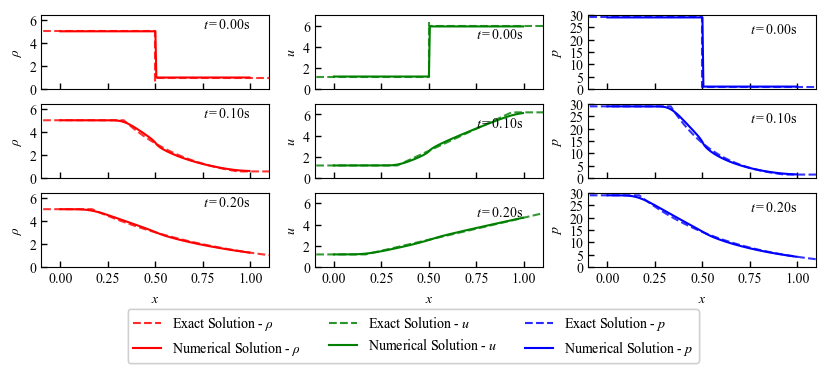

In [ ]:
roe=RoeEntroyFix(nt=1000,ts=0.2,init_l=np.array([5,np.sqrt(1.4),29]),init_r=np.array([1.0,5*np.sqrt(1.4),1.0]))#nx=200,nt=1000
roe.time_list=[0.0,0.10,0.20]
roe.solve()
roe.plot_result_t1(path='./Riemann/rho5.0-1.0,usqrt1.4-5sqrt1.4,p29.0-1.0/',ymax=[7,5*np.sqrt(1.4)+0.5,30],ymin=[0,0,0])
#roe.animation('roe_1',ymax=[7,5*np.sqrt(1.4)+0.5,30],ymin=[0,0,0])